# Hybrid Plant Disease Classification Model

This notebook combines the best elements from both ResNet50 and VGG16 approaches to build an optimized plant disease classification model using the PlantVillage dataset.

## 1. Import Required Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# For feature extraction
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model

# For machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
import joblib

# Set random seed for reproducibility
np.random.seed(42)

## 2. Set Configuration Parameters

In [4]:
# Path to dataset - update this to your path
data_dir = r"C:\Users\PC\Desktop\smartsystems\PlantVillage"

# Cache file to store features
cache_path = 'embeddings_cache.npz'

# Feature extractor selection
FEATURE_EXTRACTOR = 'resnet50'  # Options: 'resnet50', 'vgg16', 'both'

# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# PCA parameters
PCA_VARIANCE_THRESHOLD = 0.95  # Keep components that explain 95% of variance

# Training parameters
TEST_SIZE = 0.2
RANDOM_STATE = 42

## 3. Helper Functions

In [5]:
def load_image_paths_and_labels(data_dir):
    """Load image paths and their corresponding labels."""
    image_paths, labels = [], []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for fname in os.listdir(label_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(label_dir, fname))
                    labels.append(label)
    return image_paths, labels

def extract_resnet50_features(image_paths, batch_size=32, target_size=(224, 224)):
    """Extract features using ResNet50 model."""
    print("Initializing ResNet50 model...")
    model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
    
    embeddings = []
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Extracting ResNet50 features"):
        batch = image_paths[i:i+batch_size]
        imgs = []
        for p in batch:
            try:
                img = image.load_img(p, target_size=target_size)
                x = image.img_to_array(img)
                x = np.expand_dims(x, 0)
                x = resnet_preprocess(x)
                imgs.append(x)
            except Exception as e:
                print(f"Error processing {p}: {e}")
                continue
        
        if imgs:  # Make sure we have images to process
            batch_array = np.vstack(imgs)
            feats = model.predict(batch_array, verbose=0)
            embeddings.append(feats)
    
    return np.vstack(embeddings) if embeddings else np.array([])

def extract_vgg16_features(image_paths, target_size=(224, 224)):
    """Extract features using VGG16 model."""
    print("Initializing VGG16 model...")
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Model(inputs=base_model.input, outputs=base_model.output)
    
    features = []
    for img_path in tqdm(image_paths, desc="Extracting VGG16 features"):
        try:
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            img_array = vgg_preprocess(img_array)
            img_array = np.expand_dims(img_array, axis=0)
            
            feature = model.predict(img_array, verbose=0)
            feature = feature.flatten()
            features.append(feature)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    return np.array(features)

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_pca_variance(pca):
    """Plot explained variance ratio of PCA components."""
    plt.figure(figsize=(10, 6))
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(cumsum, 'b-', label='Cumulative Explained Variance')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
    plt.grid(True)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.legend()
    plt.show()

## 4. Load Image Paths and Labels

Loading images and labels...
Found 20638 images across 15 classes


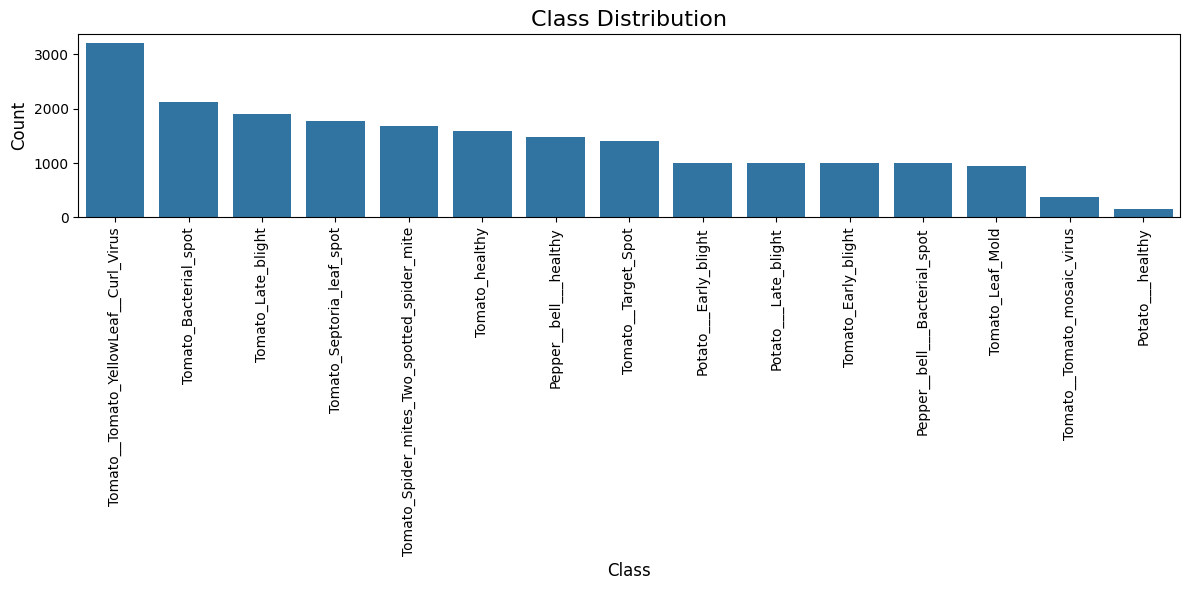

In [6]:
print("Loading images and labels...")
image_paths, labels = load_image_paths_and_labels(data_dir)
print(f"Found {len(image_paths)} images across {len(set(labels))} classes")

# Display class distribution
class_counts = pd.Series(labels).value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 5. Feature Extraction

In [7]:
# Check if cached features exist
if os.path.exists(cache_path):
    print(f"Loading cached embeddings from {cache_path}")
    data = np.load(cache_path)
    X = data['embeddings']
    print(f"Loaded features with shape {X.shape}")
else:
    # Extract features based on selected feature extractor
    if FEATURE_EXTRACTOR == 'resnet50':
        X = extract_resnet50_features(image_paths, batch_size=BATCH_SIZE, target_size=IMG_SIZE)
    elif FEATURE_EXTRACTOR == 'vgg16':
        X = extract_vgg16_features(image_paths, target_size=IMG_SIZE)
    else:  # 'both' - combine features from both models
        print("Extracting features from both ResNet50 and VGG16...")
        X_resnet = extract_resnet50_features(image_paths, batch_size=BATCH_SIZE, target_size=IMG_SIZE)
        X_vgg = extract_vgg16_features(image_paths, target_size=IMG_SIZE)
        
        # Only use images that were successfully processed by both models
        min_samples = min(X_resnet.shape[0], X_vgg.shape[0])
        X_resnet = X_resnet[:min_samples]
        X_vgg = X_vgg[:min_samples]
        
        # Concatenate features
        X = np.hstack((X_resnet, X_vgg))
        labels = labels[:min_samples]  # Adjust labels accordingly
    
    print(f"Extracted features with shape {X.shape}")
    print(f"Saving embeddings to {cache_path}")
    np.savez_compressed(cache_path, embeddings=X)

# Convert labels to numpy array
y = np.array(labels)

Loading cached embeddings from embeddings_cache.npz
Loaded features with shape (20638, 2048)


## 6. Data Preparation

In [8]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Encoded {len(le.classes_)} classes")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_encoded
)
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Encoded 15 classes
Train set: (16510, 2048), Test set: (4128, 2048)


## 7. Apply PCA for Dimensionality Reduction

Applying PCA for dimensionality reduction...
Reduced dimensions from 2048 to 1091
Explained variance: 0.9500


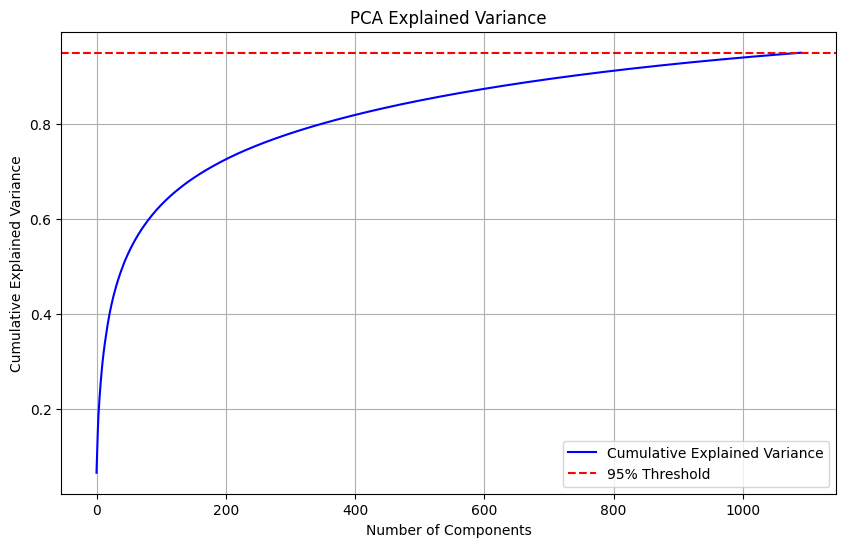

In [9]:
print("Applying PCA for dimensionality reduction...")
pca = PCA(n_components=PCA_VARIANCE_THRESHOLD, svd_solver='full')
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Reduced dimensions from {X_train_scaled.shape[1]} to {X_train_pca.shape[1]}")
print(f"Explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")

# Plot PCA variance explained
plot_pca_variance(pca)

## 8. Model Training with Grid Search

In [10]:
# Define parameter grid
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create and train model using grid search with cross-validation
print("Training KNN with grid search...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
knn = KNeighborsClassifier()
grid_search = GridSearchCV(
    knn, param_grid, cv=cv, 
    scoring='f1_macro',  # Can also try 'accuracy' or other metrics
    n_jobs=-1, verbose=1
)

grid_search.fit(X_train_pca, y_train)

# Print best parameters and results
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Create DataFrame with CV results for visualization
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results[['param_n_neighbors', 'param_weights', 'param_metric', 'mean_test_score']]
cv_results = cv_results.sort_values('mean_test_score', ascending=False).head(10)
print("\nTop 10 parameter combinations:")
cv_results

Training KNN with grid search...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.8842

Top 10 parameter combinations:


,param_n_neighbors,param_weights,param_metric,mean_test_score
5,5,distance,euclidean,0.884182
29,5,distance,minkowski,0.884182
3,3,distance,euclidean,0.883299
27,3,distance,minkowski,0.883299
7,7,distance,euclidean,0.880471
31,7,distance,minkowski,0.880471
28,5,uniform,minkowski,0.878240
4,5,uniform,euclidean,0.878240
9,9,distance,euclidean,0.877398
33,9,distance,minkowski,0.877398


## 9. Model Evaluation

Test set accuracy: 0.9159


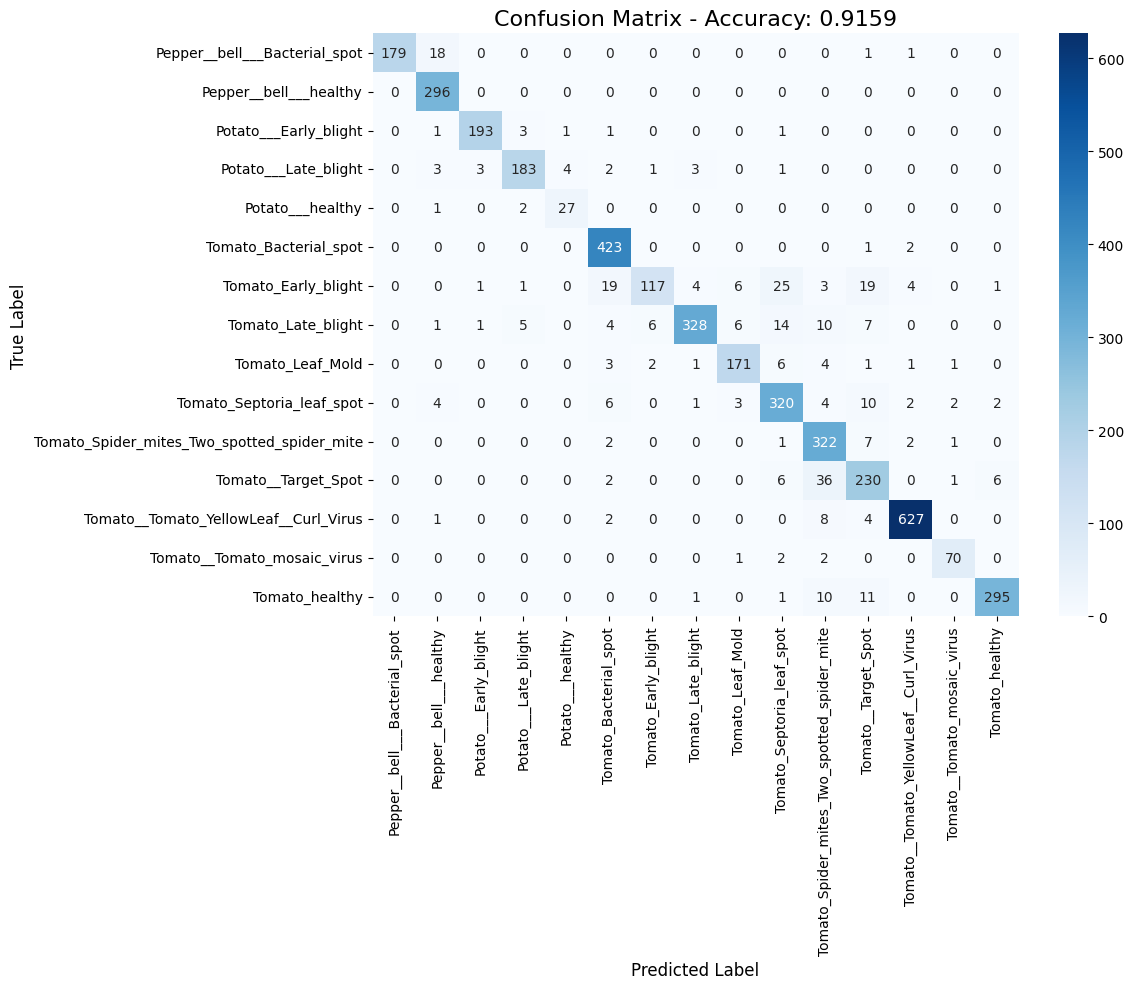

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      0.90      0.95       199
                     Pepper__bell___healthy       0.91      1.00      0.95       296
                      Potato___Early_blight       0.97      0.96      0.97       200
                       Potato___Late_blight       0.94      0.92      0.93       200
                           Potato___healthy       0.84      0.90      0.87        30
                      Tomato_Bacterial_spot       0.91      0.99      0.95       426
                        Tomato_Early_blight       0.93      0.58      0.72       200
                         Tomato_Late_blight       0.97      0.86      0.91       382
                           Tomato_Leaf_Mold       0.91      0.90      0.91       190
                  Tomato_Septoria_leaf_spot       0.85      0.90      0.88       354
Tomato_Spider_mites_Two_spotted_spider_mi

In [11]:
# Get predictions on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.4f}")

# Create and plot confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=le.classes_, title=f'Confusion Matrix - Accuracy: {accuracy:.4f}')

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

## 10. Save Model and Components

In [12]:
# Create output directory if it doesn't exist
os.makedirs('model_output', exist_ok=True)

# Save model and preprocessing components
joblib.dump(best_model, 'model_output/best_knn_model.pkl')
joblib.dump(scaler, 'model_output/feature_scaler.pkl')
joblib.dump(pca, 'model_output/pca_model.pkl')
joblib.dump(le, 'model_output/label_encoder.pkl')

# Save model info
model_info = {
    'feature_extractor': FEATURE_EXTRACTOR,
    'pca_components': X_train_pca.shape[1],
    'best_params': grid_search.best_params_,
    'best_cv_score': grid_search.best_score_,
    'test_accuracy': accuracy,
    'classes': list(le.classes_)
}

# Save as JSON
import json
with open('model_output/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)

print("Model and preprocessing components saved to 'model_output' directory.")

Model and preprocessing components saved to 'model_output' directory.


## 11. Inference Pipeline for New Images

In [ ]:
def predict_image(image_path, feature_extractor='resnet50'):
    """Predict the class of a single image."""
    # Load preprocessing components
    scaler = joblib.load('model_output/feature_scaler.pkl')
    pca = joblib.load('model_output/pca_model.pkl')
    model = joblib.load('model_output/best_knn_model.pkl')
    le = joblib.load('model_output/label_encoder.pkl')
    
    # Extract features
    if feature_extractor == 'resnet50':
        # Extract ResNet50 features
        resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
        img = image.load_img(image_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = resnet_preprocess(x)
        features = resnet_model.predict(x, verbose=0)
    else:  # vgg16
        # Extract VGG16 features
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        vgg_model = Model(inputs=base_model.input, outputs=base_model.output)
        img = load_img(image_path, target_size=(224, 224))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = vgg_preprocess(x)
        features = vgg_model.predict(x, verbose=0)
        features = features.flatten()
        features = np.expand_dims(features, axis=0)
    
    # Apply preprocessing
    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)
    
    # Make prediction
    pred_idx = model.predict(features_pca)[0]
    predicted_class = le.inverse_transform([pred_idx])[0]
    
    # Get probabilities if available
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(features_pca)[0]
        confidence = probabilities[pred_idx]
    else:
        confidence = None
    
    return predicted_class, confidence

# sample_image_path = "path/to/your/image.jpg"
# predicted_class, confidence = predict_image(sample_image_path, feature_extractor=FEATURE_EXTRACTOR)
# print(f"Predicted class: {predicted_class}")
# if confidence is not None:
#     print(f"Confidence: {confidence:.4f}")

## 12. Comparison with Alternative Models

In [ ]:
# Uncomment to run alternative models comparison

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier

# def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
#     print(f"Training {model_name}...")
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     print(f"{model_name} accuracy: {accuracy:.4f}")
#     return accuracy

# # Define models to compare
# models = {
#     'KNN (Best)': best_model,
#     'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
#     'SVM': SVC(probability=True, random_state=RANDOM_STATE),
#     'MLP': MLPClassifier(max_iter=300, random_state=RANDOM_STATE)
# }

# # Train and evaluate each model
# results = {}
# for name, model in models.items():
#     if name == 'KNN (Best)':
#         # Already trained
#         y_pred = model.predict(X_test_pca)
#         accuracy = accuracy_score(y_test, y_pred)
#     else:
#         accuracy = train_and_evaluate(model, X_train_pca, y_train, X_test_pca, y_test, name)
#     results[name] = accuracy

# # Plot results
# plt.figure(figsize=(10, 6))
# sns.barplot(x=list(results.keys()), y=list(results.values()))
# plt.title('Model Comparison', fontsize=16)
# plt.xlabel('Model', fontsize=12)
# plt.ylabel('Accuracy', fontsize=12)
# plt.ylim(0.8, 1.0)  # Adjust as needed
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()